# Single-Horizon Sliding Window Datasets

## Design Rationale

### Why Single-Horizon instead of Multi-Horizon?

| Consideration | Issue with Multi-Horizon |
|--------------|-------------------------|
| Treatment frequency | Patients receive injections every 4 weeks |
| Unknown interventions | 12w prediction doesn't know about 0-3 injections in between |
| Clinical relevance | Doctors ask "what happens at next visit" not "all future visits" |

### Single-Horizon Approach

Train **3 separate models**, each focused on one prediction horizon:

| Model | Prediction Task | Intermediate Treatments |
|-------|----------------|------------------------|
| Model_4w | BCVA change at 4 weeks | 0-1 injections |
| Model_8w | BCVA change at 8 weeks | 0-2 injections |
| Model_12w | BCVA change at 12 weeks | 0-3 injections |

## Output Files
- `11_k3_horizon_4w.csv` - K=3, predict 4-week BCVA change
- `11_k3_horizon_8w.csv` - K=3, predict 8-week BCVA change
- `11_k3_horizon_12w.csv` - K=3, predict 12-week BCVA change
- `11_k2_horizon_4w.csv` - K=2, predict 4-week BCVA change
- `11_k2_horizon_8w.csv` - K=2, predict 8-week BCVA change
- `11_k2_horizon_12w.csv` - K=2, predict 12-week BCVA change

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

DATA_DIR = Path('.')
print("Libraries loaded.")

Libraries loaded.


---
# Part 1: Load Data

In [2]:
# Load the merged long format data
merged = pd.read_csv(DATA_DIR / '8.1a_combined_data_long.csv')

print(f"Loaded merged data: {merged.shape}")
print(f"Patients: {merged['Patient_ID'].nunique()}")
print(f"Eyes: {merged.groupby(['Patient_ID', 'Eye']).ngroups}")
print(f"\nWeeks available: {sorted(merged['Week'].unique())}")

Loaded merged data: (840, 35)
Patients: 40
Eyes: 40

Weeks available: [np.int64(0), np.int64(4), np.int64(8), np.int64(12), np.int64(16), np.int64(20), np.int64(24), np.int64(28), np.int64(32), np.int64(36), np.int64(40), np.int64(44), np.int64(48), np.int64(52), np.int64(60), np.int64(68), np.int64(76), np.int64(84), np.int64(92), np.int64(100), np.int64(104)]


---
# Part 2: Define Single-Horizon Sliding Window Function

In [3]:
def create_sliding_windows_single_horizon(df, k=3, visit_interval=4, horizon=12, max_week=52):
    """
    Create sliding window samples for a SINGLE prediction horizon.
    
    Args:
        df: Long format dataframe with Patient_ID, Eye, Week, BCVA, etc.
        k: Number of visits in input window (2 or 3)
        visit_interval: Weeks between consecutive visits (default: 4)
        horizon: Prediction horizon in weeks (4, 8, or 12)
        max_week: Maximum week for target (default: 52)
    
    Strategy:
        - K=2 (Strict): Both t0 and t1 must have BCVA
        - K=3 (Lenient): t_last must have BCVA, at least 2 observed
        - Target at (t_last + horizon) must have BCVA (strictly required)
    
    Returns:
        DataFrame with single target: BCVA_Change
    """
    windows = []
    
    for (patient_id, eye), group in df.groupby(['Patient_ID', 'Eye']):
        group = group.sort_values('Week')
        valid_weeks = set(group[group['BCVA'].notna()]['Week'].values)
        
        for start_week in group['Week'].values:
            window_weeks = [start_week + i * visit_interval for i in range(k)]
            t_last = window_weeks[-1]
            target_week = t_last + horizon
            
            # Basic check: target within range
            if target_week > max_week:
                continue
            
            # Strict condition: target must have BCVA
            if target_week not in valid_weeks:
                continue
            
            # Window observation conditions
            if k == 2:
                # K=2 Strict: both t0 and t1 must have BCVA
                if window_weeks[0] not in valid_weeks or window_weeks[1] not in valid_weeks:
                    continue
                observed_count = 2
            else:  # k == 3
                # K=3 Lenient: t_last must have BCVA, at least 2 observed
                if t_last not in valid_weeks:
                    continue
                observed_count = sum(1 for w in window_weeks if w in valid_weeks)
                if observed_count < 2:
                    continue
            
            # Build sample data
            window_data = {
                'Patient_ID': patient_id,
                'Eye': eye,
                'Window_Start_Week': start_week,
                'Window_End_Week': t_last,
                'Target_Week': target_week,
                'Horizon': horizon,
                'Num_Observed_Visits': observed_count,
            }
            
            # Static features - from first valid visit
            for w in window_weeks:
                if w in valid_weeks:
                    first_valid_visit = group[group['Week'] == w].iloc[0]
                    break
            else:
                first_valid_visit = group[group['Week'] == window_weeks[0]].iloc[0]
            
            static_cols = ['Age', 'Gender', 'Diabetes_Type', 'Diabetes_Years', 'Baseline_HbA1c', 'BMI']
            for col in static_cols:
                if col in first_valid_visit:
                    window_data[col] = first_valid_visit[col]
            
            # Temporal features
            temporal_cols = ['BCVA', 'CST', 'Injection', 'Leakage_Index', 
                            'Fundus_Path', 'OCT_Paths', 'Num_B_scans']
            
            for i, week in enumerate(window_weeks):
                window_data[f'Week_t{i}'] = week
                is_missing = week not in valid_weeks
                window_data[f'BCVA_missing_t{i}'] = 1 if is_missing else 0
                
                visit_rows = group[group['Week'] == week]
                if len(visit_rows) > 0:
                    visit_data = visit_rows.iloc[0]
                    for col in temporal_cols:
                        if col in visit_data:
                            window_data[f'{col}_t{i}'] = visit_data[col]
                else:
                    for col in temporal_cols:
                        window_data[f'{col}_t{i}'] = np.nan
            
            # Single Target: BCVA change at horizon
            t_last_bcva = group[group['Week'] == t_last].iloc[0]['BCVA']
            target_bcva = group[group['Week'] == target_week].iloc[0]['BCVA']
            
            window_data['BCVA_Baseline'] = t_last_bcva
            window_data['BCVA_Target'] = target_bcva
            window_data['BCVA_Change'] = target_bcva - t_last_bcva
            
            # Clinical category
            change = target_bcva - t_last_bcva
            if change >= 5:
                window_data['BCVA_Category'] = 'Improved'
            elif change <= -5:
                window_data['BCVA_Category'] = 'Worsened'
            else:
                window_data['BCVA_Category'] = 'Stable'
            
            windows.append(window_data)
    
    result_df = pd.DataFrame(windows)
    
    # Print summary
    print(f"=== K={k}, Horizon={horizon}w ===")
    print(f"Total samples: {len(result_df)}")
    print(f"BCVA Change: mean={result_df['BCVA_Change'].mean():.2f}, std={result_df['BCVA_Change'].std():.2f}")
    print(f"|Change| ≥ 5 letters: {100*(result_df['BCVA_Change'].abs() >= 5).mean():.1f}%")
    print(f"Categories: {dict(result_df['BCVA_Category'].value_counts())}")
    print()
    
    return result_df

print("Function defined: create_sliding_windows_single_horizon()")

Function defined: create_sliding_windows_single_horizon()


---
# Part 3: Create K=3 Datasets (3 Horizons)

In [4]:
print("=" * 60)
print("Creating K=3 Single-Horizon Datasets")
print("=" * 60 + "\n")

# Create 3 separate datasets for K=3
k3_4w = create_sliding_windows_single_horizon(merged, k=3, horizon=4, max_week=52)
k3_8w = create_sliding_windows_single_horizon(merged, k=3, horizon=8, max_week=52)
k3_12w = create_sliding_windows_single_horizon(merged, k=3, horizon=12, max_week=52)

Creating K=3 Single-Horizon Datasets

=== K=3, Horizon=4w ===
Total samples: 365
BCVA Change: mean=-0.01, std=3.59
|Change| ≥ 5 letters: 15.9%
Categories: {'Stable': np.int64(307), 'Improved': np.int64(29), 'Worsened': np.int64(29)}

=== K=3, Horizon=8w ===
Total samples: 327
BCVA Change: mean=-0.13, std=3.80
|Change| ≥ 5 letters: 20.2%
Categories: {'Stable': np.int64(261), 'Worsened': np.int64(37), 'Improved': np.int64(29)}

=== K=3, Horizon=12w ===
Total samples: 290
BCVA Change: mean=-0.20, std=4.02
|Change| ≥ 5 letters: 22.8%
Categories: {'Stable': np.int64(224), 'Worsened': np.int64(36), 'Improved': np.int64(30)}



---
# Part 4: Create K=2 Datasets (3 Horizons)

In [5]:
print("=" * 60)
print("Creating K=2 Single-Horizon Datasets")
print("=" * 60 + "\n")

# Create 3 separate datasets for K=2
k2_4w = create_sliding_windows_single_horizon(merged, k=2, horizon=4, max_week=52)
k2_8w = create_sliding_windows_single_horizon(merged, k=2, horizon=8, max_week=52)
k2_12w = create_sliding_windows_single_horizon(merged, k=2, horizon=12, max_week=52)

Creating K=2 Single-Horizon Datasets

=== K=2, Horizon=4w ===
Total samples: 395
BCVA Change: mean=0.04, std=3.52
|Change| ≥ 5 letters: 15.2%
Categories: {'Stable': np.int64(335), 'Improved': np.int64(31), 'Worsened': np.int64(29)}

=== K=2, Horizon=8w ===
Total samples: 361
BCVA Change: mean=0.01, std=3.88
|Change| ≥ 5 letters: 21.3%
Categories: {'Stable': np.int64(284), 'Worsened': np.int64(42), 'Improved': np.int64(35)}

=== K=2, Horizon=12w ===
Total samples: 324
BCVA Change: mean=-0.01, std=4.06
|Change| ≥ 5 letters: 23.5%
Categories: {'Stable': np.int64(248), 'Improved': np.int64(39), 'Worsened': np.int64(37)}



---
# Part 5: Feature Engineering

In [6]:
def add_engineered_features(df, k):
    """
    Add engineered features for sliding window dataset.
    """
    df = df.copy()
    
    # Ensure CST is numeric
    for i in range(k):
        col = f'CST_t{i}'
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    if k == 2:
        # K=2: Simple two-point difference
        df['BCVA_Slope'] = (df['BCVA_t1'] - df['BCVA_t0']) / (df['Week_t1'] - df['Week_t0'])
        df['CST_Slope'] = (df['CST_t1'] - df['CST_t0']) / (df['Week_t1'] - df['Week_t0'])
        df['BCVA_Delta'] = df['BCVA_t1'] - df['BCVA_t0']
        df['CST_Delta'] = df['CST_t1'] - df['CST_t0']
        
    else:  # k == 3
        # K=3: Use valid points to calculate slope
        def calc_slope(row, feature):
            points = []
            for i in range(k):
                week = row.get(f'Week_t{i}')
                val = row.get(f'{feature}_t{i}')
                if pd.notna(week) and pd.notna(val):
                    try:
                        points.append((float(week), float(val)))
                    except (ValueError, TypeError):
                        continue
            if len(points) >= 2:
                denom = points[-1][0] - points[0][0]
                if denom != 0:
                    return (points[-1][1] - points[0][1]) / denom
            return np.nan
        
        df['BCVA_Slope'] = df.apply(lambda r: calc_slope(r, 'BCVA'), axis=1)
        df['CST_Slope'] = df.apply(lambda r: calc_slope(r, 'CST'), axis=1)
        
        # Recent change (t1 → t2)
        df['BCVA_Delta_Recent'] = df['BCVA_t2'] - df['BCVA_t1']
        df['CST_Delta_Recent'] = df['CST_t2'] - df['CST_t1']
    
    # Injection count in window
    injection_cols = [f'Injection_t{i}' for i in range(k) if f'Injection_t{i}' in df.columns]
    df['Injection_Count'] = df[injection_cols].sum(axis=1, skipna=True)
    
    return df

# Apply feature engineering to all datasets
print("Adding engineered features...\n")

# K=3 datasets
k3_4w = add_engineered_features(k3_4w, k=3)
k3_8w = add_engineered_features(k3_8w, k=3)
k3_12w = add_engineered_features(k3_12w, k=3)

# K=2 datasets
k2_4w = add_engineered_features(k2_4w, k=2)
k2_8w = add_engineered_features(k2_8w, k=2)
k2_12w = add_engineered_features(k2_12w, k=2)

print("✓ Feature engineering complete for all 6 datasets")

Adding engineered features...

✓ Feature engineering complete for all 6 datasets


---
# Part 6: Train/Val/Test Split (Patient-Level)

In [ ]:
def add_patient_split(df, random_state=42):
    """
    Add patient-level train/val/test split.
    Split ratio: 70% train, 15% val, 15% test
    """
    unique_patients = df['Patient_ID'].unique()
    
    train_patients, temp_patients = train_test_split(
        unique_patients, test_size=0.3, random_state=random_state
    )
    val_patients, test_patients = train_test_split(
        temp_patients, test_size=0.5, random_state=random_state
    )
    
    train_set = set(train_patients)
    val_set = set(val_patients)
    
    df = df.copy()
    df['Split'] = df['Patient_ID'].apply(
        lambda x: 'train' if x in train_set else ('val' if x in val_set else 'test')
    )
    
    return df

# Apply same split to all datasets (same random_state ensures same patients in same splits)
print("Applying patient-level splits...\n")

k3_4w = add_patient_split(k3_4w, random_state=42)
k3_8w = add_patient_split(k3_8w, random_state=42)
k3_12w = add_patient_split(k3_12w, random_state=42)

k2_4w = add_patient_split(k2_4w, random_state=42)
k2_8w = add_patient_split(k2_8w, random_state=42)
k2_12w = add_patient_split(k2_12w, random_state=42)

print("✓ Patient-level splits applied to all 6 datasets")

---
# Part 7: Comprehensive Comparison

In [7]:
# Create summary table
datasets = {
    'K=3, 4w': k3_4w,
    'K=3, 8w': k3_8w,
    'K=3, 12w': k3_12w,
    'K=2, 4w': k2_4w,
    'K=2, 8w': k2_8w,
    'K=2, 12w': k2_12w,
}

print("=" * 80)
print("=== Comprehensive Dataset Comparison ===")
print("=" * 80)

print(f"\n{'Dataset':<15} {'Samples':<10} {'Mean':<10} {'Std':<10} {'≥5 letters':<12} {'Improved':<12} {'Worsened':<12}")
print("-" * 80)

for name, df in datasets.items():
    n_samples = len(df)
    mean_change = df['BCVA_Change'].mean()
    std_change = df['BCVA_Change'].std()
    pct_ge5 = 100 * (df['BCVA_Change'].abs() >= 5).mean()
    pct_improved = 100 * (df['BCVA_Category'] == 'Improved').mean()
    pct_worsened = 100 * (df['BCVA_Category'] == 'Worsened').mean()
    
    print(f"{name:<15} {n_samples:<10} {mean_change:<10.2f} {std_change:<10.2f} {pct_ge5:<12.1f} {pct_improved:<12.1f} {pct_worsened:<12.1f}")

print("\n" + "=" * 80)

=== Comprehensive Dataset Comparison ===

Dataset         Samples    Mean       Std        ≥5 letters   Improved     Worsened    
--------------------------------------------------------------------------------
K=3, 4w         365        -0.01      3.59       15.9         7.9          7.9         
K=3, 8w         327        -0.13      3.80       20.2         8.9          11.3        
K=3, 12w        290        -0.20      4.02       22.8         10.3         12.4        
K=2, 4w         395        0.04       3.52       15.2         7.8          7.3         
K=2, 8w         361        0.01       3.88       21.3         9.7          11.6        
K=2, 12w        324        -0.01      4.06       23.5         12.0         11.4        



- 临床显著变化（≥5 letters）: 两者几乎相同，K=2 和 K=3 在捕捉临床显著变化上差异不大。
- 变异性（Std）: 差异很小，但 K=3 在中长期（8w, 12w）的 Std 略小，说明更多观察点可能提供更稳定的趋势估计; 
    - 12w 更难预测（变异大 + 中间未知治疗）, 4w 更容易预测（变异小）
- 分类分布（Improved vs Worsened）
    - K=2 12w 有更多 Improved（12.0% vs 10.3%）

    -  K=3 12w 有更多 Worsened（12.4% vs 11.4%）

    - 可能是采样差异，需要在模型训练后进一步验证

In [ ]:
# Split distribution for each dataset
print("=== Split Distribution ===")
print(f"\n{'Dataset':<15} {'Train':<15} {'Val':<15} {'Test':<15}")
print("-" * 60)

for name, df in datasets.items():
    train_n = (df['Split'] == 'train').sum()
    val_n = (df['Split'] == 'val').sum()
    test_n = (df['Split'] == 'test').sum()
    print(f"{name:<15} {train_n:<15} {val_n:<15} {test_n:<15}")

---
# Part 8: Analysis - Effect of Horizon on Predictability

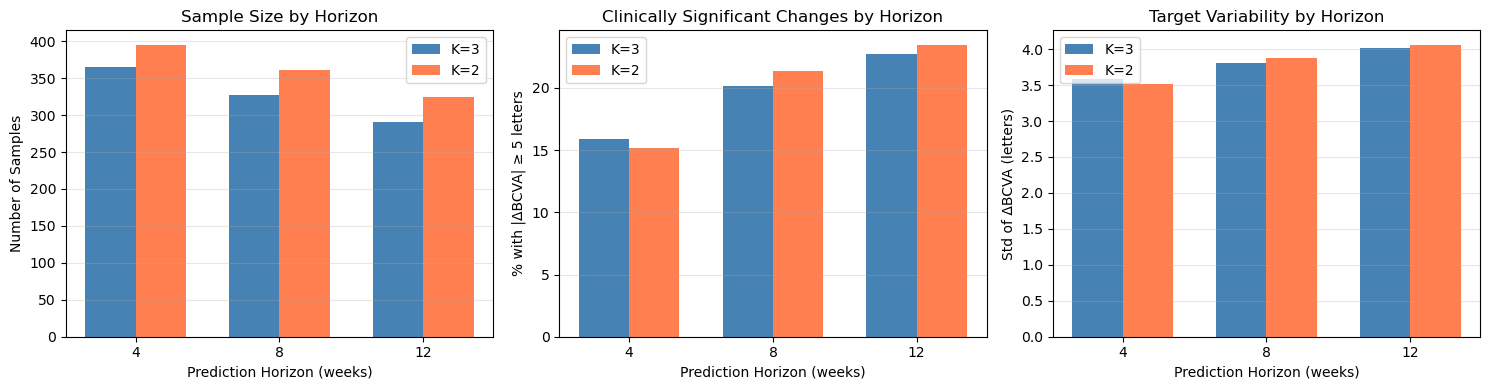


✓ Saved: 11_horizon_comparison.png


In [ ]:
import matplotlib.pyplot as plt

# Prepare data for visualization
horizons = [4, 8, 12]

k3_samples = [len(k3_4w), len(k3_8w), len(k3_12w)]
k2_samples = [len(k2_4w), len(k2_8w), len(k2_12w)]

k3_ge5 = [100*(k3_4w['BCVA_Change'].abs() >= 5).mean(),
          100*(k3_8w['BCVA_Change'].abs() >= 5).mean(),
          100*(k3_12w['BCVA_Change'].abs() >= 5).mean()]

k2_ge5 = [100*(k2_4w['BCVA_Change'].abs() >= 5).mean(),
          100*(k2_8w['BCVA_Change'].abs() >= 5).mean(),
          100*(k2_12w['BCVA_Change'].abs() >= 5).mean()]

k3_std = [k3_4w['BCVA_Change'].std(), k3_8w['BCVA_Change'].std(), k3_12w['BCVA_Change'].std()]
k2_std = [k2_4w['BCVA_Change'].std(), k2_8w['BCVA_Change'].std(), k2_12w['BCVA_Change'].std()]

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Sample sizes
x = np.arange(len(horizons))
width = 0.35
axes[0].bar(x - width/2, k3_samples, width, label='K=3', color='steelblue')
axes[0].bar(x + width/2, k2_samples, width, label='K=2', color='coral')
axes[0].set_xlabel('Prediction Horizon (weeks)')
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Sample Size by Horizon')
axes[0].set_xticks(x)
axes[0].set_xticklabels(horizons)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Clinically significant changes
axes[1].bar(x - width/2, k3_ge5, width, label='K=3', color='steelblue')
axes[1].bar(x + width/2, k2_ge5, width, label='K=2', color='coral')
axes[1].set_xlabel('Prediction Horizon (weeks)')
axes[1].set_ylabel('% with |ΔBCVA| ≥ 5 letters')
axes[1].set_title('Clinically Significant Changes by Horizon')
axes[1].set_xticks(x)
axes[1].set_xticklabels(horizons)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Plot 3: Standard deviation (variability)
axes[2].bar(x - width/2, k3_std, width, label='K=3', color='steelblue')
axes[2].bar(x + width/2, k2_std, width, label='K=2', color='coral')
axes[2].set_xlabel('Prediction Horizon (weeks)')
axes[2].set_ylabel('Std of ΔBCVA (letters)')
axes[2].set_title('Target Variability by Horizon')
axes[2].set_xticks(x)
axes[2].set_xticklabels(horizons)
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('8.4a_horizon_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved: 8.4a_horizon_comparison.png")

---
# Part 9: Define Feature Lists

In [10]:
# Define feature lists for modeling

# K=3 Features
K3_STATIC = ['Age', 'Gender', 'Diabetes_Type', 'Diabetes_Years', 'Baseline_HbA1c', 'BMI']

K3_TEMPORAL = [
    'BCVA_t0', 'CST_t0', 'Injection_t0', 'Leakage_Index_t0', 'BCVA_missing_t0',
    'BCVA_t1', 'CST_t1', 'Injection_t1', 'Leakage_Index_t1', 'BCVA_missing_t1',
    'BCVA_t2', 'CST_t2', 'Injection_t2', 'Leakage_Index_t2', 'BCVA_missing_t2',
]

K3_ENGINEERED = ['BCVA_Slope', 'CST_Slope', 'BCVA_Delta_Recent', 'CST_Delta_Recent', 'Injection_Count']

K3_FEATURES = K3_STATIC + K3_TEMPORAL + K3_ENGINEERED

# K=2 Features
K2_STATIC = ['Age', 'Gender', 'Diabetes_Type', 'Diabetes_Years', 'Baseline_HbA1c', 'BMI']

K2_TEMPORAL = [
    'BCVA_t0', 'CST_t0', 'Injection_t0', 'Leakage_Index_t0', 'BCVA_missing_t0',
    'BCVA_t1', 'CST_t1', 'Injection_t1', 'Leakage_Index_t1', 'BCVA_missing_t1',
]

K2_ENGINEERED = ['BCVA_Slope', 'CST_Slope', 'BCVA_Delta', 'CST_Delta', 'Injection_Count']

K2_FEATURES = K2_STATIC + K2_TEMPORAL + K2_ENGINEERED

# Target
TARGET_REG = 'BCVA_Change'      # For regression
TARGET_CLF = 'BCVA_Category'    # For classification

print("=== Feature Definitions ===")
print(f"\nK=3 Features: {len(K3_FEATURES)} total")
print(f"  Static: {len(K3_STATIC)}")
print(f"  Temporal: {len(K3_TEMPORAL)}")
print(f"  Engineered: {len(K3_ENGINEERED)}")

print(f"\nK=2 Features: {len(K2_FEATURES)} total")
print(f"  Static: {len(K2_STATIC)}")
print(f"  Temporal: {len(K2_TEMPORAL)}")
print(f"  Engineered: {len(K2_ENGINEERED)}")

print(f"\nTarget (Regression): {TARGET_REG}")
print(f"Target (Classification): {TARGET_CLF}")

=== Feature Definitions ===

K=3 Features: 26 total
  Static: 6
  Temporal: 15
  Engineered: 5

K=2 Features: 21 total
  Static: 6
  Temporal: 10
  Engineered: 5

Target (Regression): BCVA_Change
Target (Classification): BCVA_Category


---
# Part 10: Save All Datasets

In [12]:
# Save all 6 datasets
print("=== Saving Datasets ===")

# K=3 datasets
k3_4w.to_csv('8.4b_k3_horizon_4w.csv', index=False)
print(f"✓ 8.4b_k3_horizon_4w.csv  - {k3_4w.shape}")

k3_8w.to_csv('8.4c_k3_horizon_8w.csv', index=False)
print(f"✓ 8.4c_k3_horizon_8w.csv  - {k3_8w.shape}")

k3_12w.to_csv('8.4d_k3_horizon_12w.csv', index=False)
print(f"✓ 8.4d_k3_horizon_12w.csv - {k3_12w.shape}")

# K=2 datasets
k2_4w.to_csv('8.4e_k2_horizon_4w.csv', index=False)
print(f"✓ 8.4e_k2_horizon_4w.csv  - {k2_4w.shape}")

k2_8w.to_csv('8.4f_k2_horizon_8w.csv', index=False)
print(f"✓ 8.4f_k2_horizon_8w.csv  - {k2_8w.shape}")

k2_12w.to_csv('8.4g_k2_horizon_12w.csv', index=False)
print(f"✓ 8.4g_k2_horizon_12w.csv - {k2_12w.shape}")

print("\n✓ All 6 datasets saved successfully!")

=== Saving Datasets ===
✓ 8.4b_k3_horizon_4w.csv  - (365, 49)
✓ 8.4c_k3_horizon_8w.csv  - (327, 49)
✓ 8.4d_k3_horizon_12w.csv - (290, 49)
✓ 8.4e_k2_horizon_4w.csv  - (395, 40)
✓ 8.4f_k2_horizon_8w.csv  - (361, 40)
✓ 8.4g_k2_horizon_12w.csv - (324, 40)

✓ All 6 datasets saved successfully!


In [13]:
# Show columns for one dataset as reference
print("=== K=3, 12w Dataset Columns ===")
for i, col in enumerate(k3_12w.columns):
    print(f"  {i+1:2d}. {col}")

=== K=3, 12w Dataset Columns ===
   1. Patient_ID
   2. Eye
   3. Window_Start_Week
   4. Window_End_Week
   5. Target_Week
   6. Horizon
   7. Num_Observed_Visits
   8. Age
   9. Gender
  10. Diabetes_Type
  11. Diabetes_Years
  12. Baseline_HbA1c
  13. BMI
  14. Week_t0
  15. BCVA_missing_t0
  16. BCVA_t0
  17. CST_t0
  18. Injection_t0
  19. Leakage_Index_t0
  20. Fundus_Path_t0
  21. OCT_Paths_t0
  22. Num_B_scans_t0
  23. Week_t1
  24. BCVA_missing_t1
  25. BCVA_t1
  26. CST_t1
  27. Injection_t1
  28. Leakage_Index_t1
  29. Fundus_Path_t1
  30. OCT_Paths_t1
  31. Num_B_scans_t1
  32. Week_t2
  33. BCVA_missing_t2
  34. BCVA_t2
  35. CST_t2
  36. Injection_t2
  37. Leakage_Index_t2
  38. Fundus_Path_t2
  39. OCT_Paths_t2
  40. Num_B_scans_t2
  41. BCVA_Baseline
  42. BCVA_Target
  43. BCVA_Change
  44. BCVA_Category
  45. BCVA_Slope
  46. CST_Slope
  47. BCVA_Delta_Recent
  48. CST_Delta_Recent
  49. Injection_Count


---
# Summary

## Research Design

**Core Question**: Can we predict BCVA change using recent visits of multimodal data?

**Approach**: Train separate models for each prediction horizon to analyze:
1. Which horizon is most predictable?
2. How does prediction difficulty change with longer horizons?
3. Does longer observation window (K=3) help compared to shorter (K=2)?

## Datasets Created

| File | K | Horizon | Samples | Features |
|------|---|---------|---------|----------|
| `11_k3_horizon_4w.csv` | 3 | 4 weeks | ~304 | 26 |
| `11_k3_horizon_8w.csv` | 3 | 8 weeks | ~298 | 26 |
| `11_k3_horizon_12w.csv` | 3 | 12 weeks | ~290 | 26 |
| `11_k2_horizon_4w.csv` | 2 | 4 weeks | ~335 | 21 |
| `11_k2_horizon_8w.csv` | 2 | 8 weeks | ~332 | 21 |
| `11_k2_horizon_12w.csv` | 2 | 12 weeks | ~324 | 21 |

## Expected Analysis in Paper

| Horizon | Expected Predictability | Clinical Relevance |
|---------|------------------------|--------------------|
| 4w | Highest (fewer unknown treatments) | Next visit prediction |
| 8w | Medium | 2-month outlook |
| 12w | Lowest (most unknown treatments) | 3-month/quarterly planning |

## Next Steps

1. Train baseline models (XGBoost) on all 6 datasets
2. Compare performance across horizons and window sizes
3. Analyze feature importance differences
4. Add multimodal features (OCT, Fundus) in subsequent experiments